In [3]:
!pip install -q plotly
!pip install -q lightgbm

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as  lgb
import warnings

py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
seed = 4432

In [38]:
train_data_url = "https://storage.googleapis.com/kagglesdsdata/competitions/5407/868283/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1690976564&Signature=PkRPBKVNa4Nr0HTpW%2BIw21YLYExiv7DJ6tGOERYuzJ0skOhJMQwR2Qvz80S5VuDwwnw0nfGTg%2FqDLgsB0CCzW90anOmKyrfCHQHtN7czUFDUyCQDepklEQn7q%2FOyVcRqyLKrG7JF3z88en0MwH9gr78FNiW3F0Km6NUbCVKCStrYCHQ33xlrm4ZvFGkK%2B3gjcotPNMKSKyiLraremRaCB9j3BfntmG8CAbpXNya39FRQQ6tEk1AdhqaLtAaetBJx6TDH7R4F9HwUJHNiGr8DAxyHhluobHWldfvpSS%2BHLHJgpKhTYJ7s77jHA4UwA4aEZhP1GzWGhN0qMiZUp3JA0A%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv"
test_data_url = "https://storage.googleapis.com/kagglesdsdata/competitions/5407/868283/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1690976409&Signature=dP9wdJjoERFxoLQBOyPJWXhKctdDgDOmqLORHV1L7Z5O%2BoaKtvJ2FPeMHHDMFlB51VcypFO63FifJeIg0rN9XWHNVOaQvxdiAD9cX3jQttz%2BNof5o4JxhbIZh9pC3qxnYPoZimD82XdmX7vHONBuNtgMUQdoegdvXYBjw%2B%2F%2BpZRMiMundyDO5tfst0N3wYA3dhlH4%2BYbeCqtYsKmTSv1cD5JQuAyfUV1u%2Fmpfs5%2FVinAiKjGTgtbZiDzlbonkNNl4BIgx1tydVPAmI4i0e76Qe8P%2F0Sb5UB8UYjIvwfVdL7UUkyQ1K1wyqQ4M%2FHN9l9BIXlWXZihVM0wLy6VsGk35A%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv"

In [39]:
train = pd.read_csv(train_data_url)
test = pd.read_csv(test_data_url)
print('Number of rows and columns in train dataset:', train.shape)
print('Number of rows and columns in test dataset:', test.shape)

Number of rows and columns in train dataset: (1460, 81)
Number of rows and columns in test dataset: (1459, 80)


In [40]:
# train.head()
# test.head()

In [41]:
no_missing_col = [c for c in train.columns if train[c].isnull().sum() == 0]
missing_col = [c for c in train.columns if train[c].isnull().sum() > 0]
print(f'Missing value in {len(missing_col)} columns\nNo missing value in {len(no_missing_col)} columns')

Missing value in 19 columns
No missing value in 62 columns


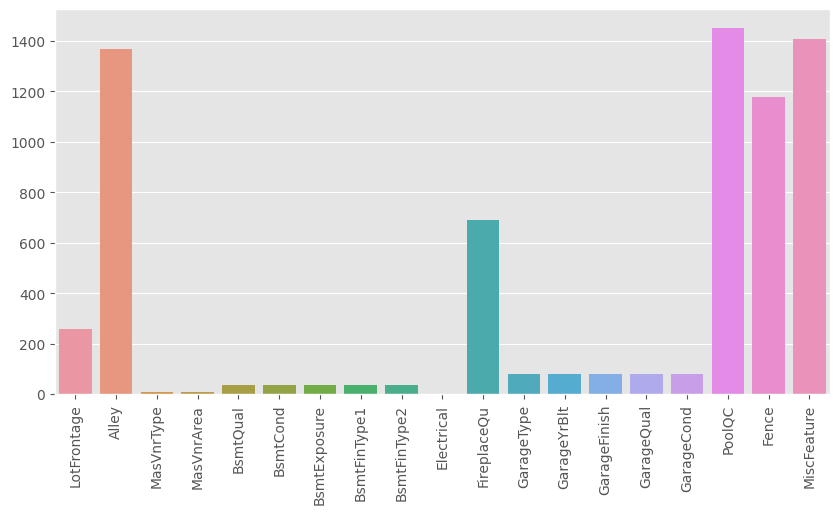

In [42]:
missing = train[missing_col].isnull().sum()

plt.figure(figsize = (10, 5))
sns.barplot(x = missing.index, y = missing.values)
plt.xticks(rotation = 90)
plt.show()

In [43]:
no_missing_col = [c for c in test.columns if test[c].isnull().sum() == 0]
missing_col = [c for c in test.columns if test[c].isnull().sum() > 0]
print(f'Missing value in {len(missing_col)} columns \nNo missing value in {len(no_missing_col)} columns')

Missing value in 33 columns 
No missing value in 47 columns


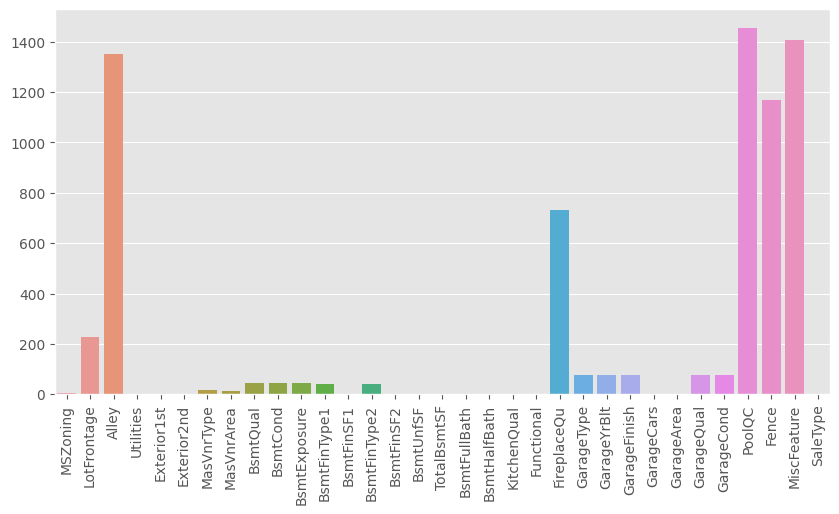

In [44]:
missing = test[missing_col].isnull().sum()
plt.figure(figsize = (10, 5))
sns.barplot(x = missing.index, y = missing.values)
plt.xticks(rotation = 90)
plt.show()

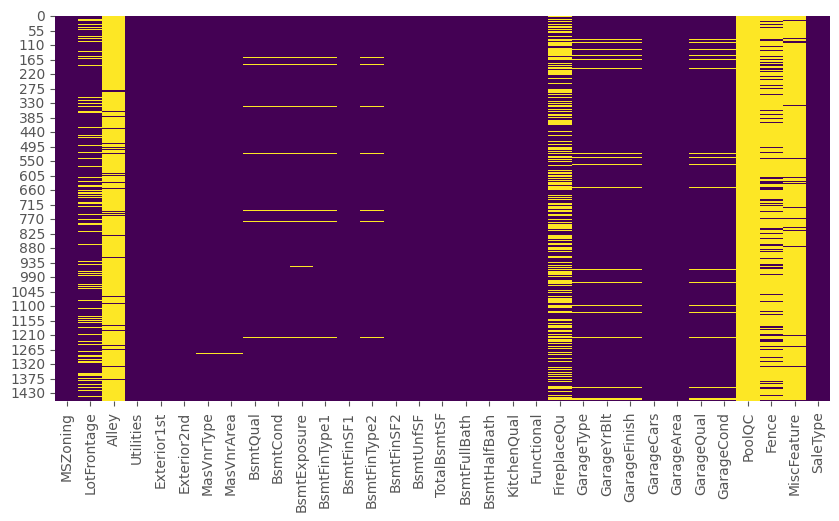

In [45]:
missing = train[missing_col].isnull()
plt.figure(figsize = (10, 5))
sns.heatmap(missing, cbar = False, cmap = 'viridis')
plt.show()

In [46]:
def regression_plot(df, column = ""):
    """ Regression plot: with pearsonr correlation value """
    cor = round(df[['SalePrice', column]].corr().iloc[0, 1], 3)
    sns.jointplot(x = df[column], y = df['SalePrice'], kind = 'reg', label = 'r: ' + str(cor), color = 'blue')
    plt.legend()
    plt.title('Regression plot ')

In [57]:
train_test = pd.concat([train, test], axis = 0)
train_test.shape

(2919, 74)

In [58]:
# The below columns data was retrieve after the EDA in the EDA file
drop_col = list(set(['Street', 'Alley', 'Utilities', 'RoofMatl', 'Heating', 'PoolQC', 'MiscFeature']))
categorical_col = list(set(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']))
numeric_col = list(set(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']))

In [59]:
train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)

KeyError: "['RoofMatl', 'Heating', 'Street', 'Utilities', 'MiscFeature', 'PoolQC', 'Alley'] not found in axis"

In [ ]:
def one_hot_encoding(df, columns, nan_as_category = True, drop_first = True):
    """ One Hot Encoding: of categorical variable """
    print(10 * '*' + 'One Hot Encoding: ' , df.shape, 10 * '*')
    df = pd.get_dummies(data = df, columns = columns, drop_first = drop_first, dummy_na = nan_as_category)
    print(10 * '*', 'After One Hot Encoding: ', df.shape, 10 * '*')
    return df

In [60]:
train_test = one_hot_encoding(train_test, columns = categorical_col)

**********One Hot Encoding:  (2919, 74) **********
********** After One Hot Encoding:  (2919, 340) **********


In [61]:
def fill_missing_value(df, column = ""):
    """ Fill missing value with Mean """
    for c in column:
        if df[c].isnull().sum() > 0:
            df[c] = df[c].fillna(df[c].mean())
    print('Check missing value: ', df.isnull().sum().sum())
    return df

In [62]:
train_test = fill_missing_value(train_test, numeric_col)

Check missing value:  1459


In [63]:
def descriptive_statistics(df, columns = ""):
    """ Descriptive statistics feature genarating function: Mean, Median, Q1, Q3 """
    print('*' * 10, ' Descriptive statistics feature ', '*' * 10)
    print('Before shape: ', df.shape)
    mean = df[columns].mean()
    median = df[columns].median()
    Q1 = np.percentile(df[columns], 25, axis = 0)
    Q3 = np.percentile(df[columns], 75, axis = 0)
    for i, j in enumerate(columns):
        df['mean_' + j] = (df[j] < mean[i]).astype('int8')
        df['median_' + j] = (df[j] > median[i]).astype('int8')
        df['Q1_' + j] = (df[j] < Q1[i]).astype('int8')
        df['Q3_' + j] = (df[j] > Q3[i]).astype('int8')
    print('After shape: ', df.shape)
    return df

In [64]:
train_test = descriptive_statistics(train_test, columns = numeric_col)

**********  Descriptive statistics feature  **********
Before shape:  (2919, 340)
After shape:  (2919, 428)


In [65]:
length = train.shape[0]
test_id = test['Id']
train1 = train_test[:length]
test1 = train_test[length:]
X = train1.drop(['Id', 'SalePrice'], axis = 1)
y = np.log1p(train1['SalePrice'])
new_test = test1.drop(['Id', 'SalePrice'], axis = 1)

del train1, test1

In [67]:
reg = Ridge(alpha = 1.0)
rscv = RandomizedSearchCV(reg, cv = 5, param_distributions  = {'alpha': np.linspace(0,20,100)}, random_state = seed)
rscv.fit(X, y)

RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': array([ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
        1.01010101,  1.21212121,  1.41414141,  1.61616162,  1.81818182,
        2.02020202,  2.22222222,  2.42424242,  2.62626263,  2.82828283,
        3.03030303,  3.23232323,  3.43434343,  3.63636364,  3.83838384,
        4.04040404,  4.24242424,  4.44444444,  4.64646465,  4.84848485,
        5.05050...
       14.14141414, 14.34343434, 14.54545455, 14.74747475, 14.94949495,
       15.15151515, 15.35353535, 15.55555556, 15.75757576, 15.95959596,
       16.16161616, 16.36363636, 16.56565657, 16.76767677, 16.96969697,
       17.17171717, 17.37373737, 17.57575758, 17.77777778, 17.97979798,
       18.18181818, 18.38383838, 18.58585859, 18.78787879, 18.98989899,
       19.19191919, 19.39393939, 19.5959596 , 19.7979798 , 20.        ])},
                   random_state=4432)

In [68]:
rscv.best_params_

{'alpha': 8.686868686868687}

In [70]:
_k = 5
kf = KFold(n_splits = _k, random_state = seed, shuffle = True)
final_pred = 0
rmse = []
r_square = []

In [71]:
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Modelling {i + 1} of {kf.n_splits} fold')
    X_train, X_valid = X.loc[train_index], X.loc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Regression
    reg = Ridge(alpha = rscv.best_params_['alpha'])
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_valid)
    final_pred += reg.predict(new_test)
    r2 = reg.score(X_valid, y_valid)
    r_square.append(r2)
    print('*' * 10,' R sqaure: ', round(r2, 3), ' *' * 10, '\n')
    rmse.append(mean_squared_error(y_valid, y_pred) ** 0.5)

Modelling 1 of 5 fold
**********  R sqaure:  0.917  * * * * * * * * * * 

Modelling 2 of 5 fold
**********  R sqaure:  0.901  * * * * * * * * * * 

Modelling 3 of 5 fold
**********  R sqaure:  0.881  * * * * * * * * * * 

Modelling 4 of 5 fold
**********  R sqaure:  0.618  * * * * * * * * * * 

Modelling 5 of 5 fold
**********  R sqaure:  0.91  * * * * * * * * * * 



In [72]:
print(rmse,'\nRMSE:', np.mean(rmse))

[0.10565746728341223, 0.1277549076189037, 0.14474465894937066, 0.23404831555531594, 0.12506345747495168] 
RMSE: 0.14745376137639082


Text(0.5, 1.0, 'Residual plot')

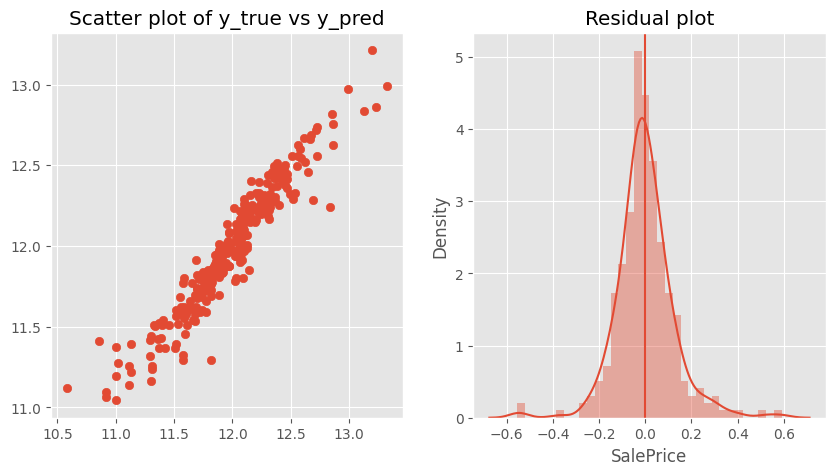

In [73]:
f = plt.figure(figsize= (10, 5))
ax = f.add_subplot(121)
ax.scatter(y_valid, y_pred)
plt.title('Scatter plot of y_true vs y_pred')
residual = y_valid - y_pred
ax = f.add_subplot(122)
sns.distplot(residual, ax = ax)
plt.axvline(residual.mean())
plt.title('Residual plot')

In [74]:
pred = np.expm1(final_pred / kf.n_splits)
results = pd.DataFrame({'Id': test_id, 'SalePrice': pred})
print('Shape: ', results.shape)
results.head()

Shape:  (1459, 2)


,Id,SalePrice
0,1461,122261.647350
1,1462,177744.229656
2,1463,199259.864153
3,1464,204766.629145
4,1465,188073.128795
